<a href="https://colab.research.google.com/github/K-Molloy/SCC413/blob/main/Lab_Week14_Task01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build Your Own MLP - XOR


In this Jupyter notebook you will implement a simple neural network from scratch.
To understand what a NN is we will limit ourselves to a very simple task, namely that of solving the exclusive or (XOR) function. We release a second notebook for self-study where you can then use the acquired concepts (and most of the code) to attack a real perception problem - that of eye-gaze estimation.

In this course, we normally use Deep Learning library [TensorFlow](https://tensorflow.org) to build neural network powered applications. However, for learning purposes it is better to actually implement everything yourself in plain Python and NumPy.

## Setup


First let's import the necessary libraries and let's configure essential building blocks such as a pseudo-random number generator:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 56

np.random.seed(RANDOM_SEED)

We have now imported and configured useful helper libraries such as [matlibplot](https://matplotlib.org/) for plotting and [NumPy](http://www.numpy.org/) - the workhorse of numerical and scientific programming. If you are not familiar with these you should follow up on the [various](https://docs.scipy.org/doc/numpy/user/quickstart.html) [tutorials](https://cs231n.github.io/python-numpy-tutorial/) available online.


## Overview


The XOR problem is a toy example to show that linear models can fail at seemingly simple tasks. Consider this (truth-) table:

| x1 | x2 | y |
|--------|--------|--------|
|   0    |   0    |    0   |    
|   0    |   1    |    1   |    
|   1    |   0    |    1   |
|   1    |   1    |    0   | 

The task of the model is to predict the `y` column given the two input columns `x1` and `x2`. In other words, we must output `1` *iff* (if and only if) either of the inputs is `1` but not otherwise. Obviously, we want to learn this mapping from data, i.e. the 4 data points we have in this table. We can think of this as a classification problem that we can visualize as follows (*green* represents `1` and *blue* represents `0`):

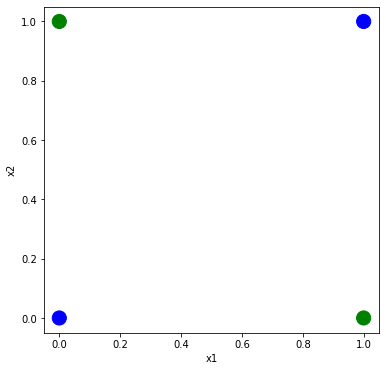

In [2]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

# Colors corresponding to class labels y.
colors = ['green' if y_ == 1 else 'blue' for y_ in y] 

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.scatter(X[:,0],X[:,1],s=200,c=colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Plotting the problem makes it clear why linear models will fail to do so - there is simply no straight line in $\mathbb{R}^2$ that can separate the green from the blue points. The neural network that we will build in the following is a simple feed-forward network that looks like this:

<img src="https://i.imgur.com/xOSTCVe.png" align="middle" hspace="20px" vspace="5px">

In the input layer we feed the two values $x_1$ and $x_2$ which we summarize into an input vector $\mathbf{x} = [x_1, x_2]^T \in \{0, 1\}^2$. The hidden layer does some computation and the output layer produces the result $\hat{y} \in \mathbb{R}$. The associated *weights* with each layer - aka learnable parameters of the network - are matrices $\mathbf{W}_1 \in \mathbb{R}^{2 \times 3}$ and $\mathbf{W}_2 \in \mathbb{R}^{3 \times 1}$. We can also write this down in a more mathematical way:

$$\mathbf{a} = g\left(\mathbf{h}\right) = g\left( \mathbf{x}^\mathrm{T}\mathbf{W}_1 \right)$$
$$\hat{y} = \mathbf{a}^\mathrm{T}\mathbf{W}_2$$

Here, the function $g$ is an activation function, which is not explicitly shown in the above image. The choice of the activation function is crucial - we will come back to this later.

### Building Blocks
With this preliminaries out of the way, we are ready to implement our neural network and training procedure. For this, we need to implement the following building blocks:

* An **activation function**, i.e. $g$
* The **forward pass**, i.e. computing $\hat{y}$.
* A **loss function**, i.e. a quantity that measures how far away $\hat{y}$ is from the true value $y$.
* The **backward pass**, i.e. computing the gradients w.r.t. the loss function
* An **optimizer**, i.e. an algorithm that updates the trainable weights of the network based on the gradients

## Activation Function


Let's start with an easy task. In the lecture you have seen that in deep neural networks linear layers are commonly followed by a non-linear activation function. Without these neural networks would only be able to approximate affine functions and hence would be a lot less powerful. 
The perceptron (MLP) algorithm uses a step-function as activation function. However, for various reasons in DL one uses different types of activation functions. One reason is that the activation function should be differentiable and should have a derivative that leads to fast convergence.

In this tutorial we will be working with the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) as activation function. It has several appealing properties: it is bounded, it is fully differentiable and has a positive derivative at any point. Furthermore, the sigmoid function maps real-valued inputs to the (0,1) range. This is useful because it allows us to interpret its output as a probability value. The sigmoid function is defined by: 
$$\sigma(\mathbf{x})=\frac{1}{1+e^{-\mathbf{x}}}$$

In order to train our neural network we will also need it's derivative which is given by:
$$\frac{\partial \sigma(\mathbf{x})}{\partial \mathbf{x}}=\sigma(\mathbf{x})\odot(1-\sigma(\mathbf{x}))$$
where $\odot$ stands for element-wise multiplication.

In [3]:
def sigmoid(x):
  """
  Computes the sigmoid function sigm(input) = 1/(1+exp(-input))
  """
  return 1 / (1 + np.exp(-x))

def sigmoid_(y):
  """
  Computes the derivative of sigmoid funtion. sigmoid(y) * (1.0 - sigmoid(y)). 
  The way we implemented this requires that the input y is already sigmoided
  """
  return y * (1-y)

To better understand the sigmoid function and its derivative, let's plot it.

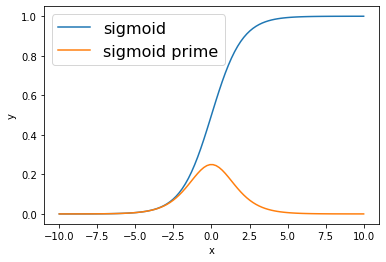

In [4]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_(sig)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

If you need some background info on how we got here check out the full derivation of this [here](http://kawahara.ca/how-to-compute-the-derivative-of-a-sigmoid-function-fully-worked-example/).


## Forward Pass


Next, we have to implement the "body" of the neural network, in other words, how we compute the output from the inputs. For a feed-forward network like ours, this is actually just a bunch of matrix multiplications followed by sigmoid activations.

As we are usually dealing with a lot of data samples, we don't feed them to the model individually, but organise several of them together into **batches**. We can think of this as stacking the input vectors row-wise into a matrix $\mathbf{X}$. In our case, we only have 4 samples, so $\mathbf{X}$ will have shape $4 \times 2$. This allows us to rewrite the computations as:

$$
\mathbf{\hat{y}} = \sigma\left(\mathbf{X} \mathbf{W}_1\right)\mathbf{W}_2
$$

Now, both $\mathbf{H} := \mathbf{X} \mathbf{W}_1$ and $\mathbf{A} := \sigma(\mathbf{H})$ have dimensionality $4 \times 3$ and each hidden unit is computed by taking a weighted average of the samples' input features. This matrix multiplication is essentially how a dense (aka linear, feed-forward) layer looks like. Let's write that in code.

In [5]:
def dense(inputs, weights):
    """A simple dense layer."""
    return np.matmul(inputs, weights)

With this, we are now ready to define the forward pass of our network. To this end, we have to initialize the weights, so let's do that first.

In [6]:
input_size = 2
hidden_size = 3
output_size = 1

def initialize_weights(input_sz, hidden_sz, output_sz):
    # weights for hidden layer, shape: 2x3
    w1 = np.random.uniform(size=(input_sz, hidden_sz))
    # weights for output layer, shape: 3x1
    w2 = np.random.uniform(size=(hidden_sz, output_sz))
    return w1, w2
    
w1, w2 = initialize_weights(input_size, hidden_size, output_size)

Now we use these weights to define the forward pass.

In [7]:
def forward_pass(X, w1, w2):
    # Step 1: Calculate weighted average of inputs (output shape: 4x3)
    net_hidden = dense(X, w1)
    
    # Step 2: Calculate the result of the sigmoid activation function (shape: 4x3)
    act_hidden = sigmoid(net_hidden)
    
    # Step 3: Calculate output of neural network (output shape: 4x1)
    y_hat = dense(act_hidden, w2)
    
    return act_hidden, y_hat

## Loss Function


Next we need to measure how good or bad the output of the network is - in other words, we need to define a loss function. The choice of loss function is crucial for the overall learning success as its gradients provide the supervision signal that drives the optimization. For this toy example, we simply choose the mean squared error (MSE) between the value predicted by the model and the ground-truth label.

$$ \mathcal{L} = \frac{1}{N}\sum_{i=1}^N\frac{1}{2} \| \hat{y}_i - y_i \|^2_2 $$

Note that the factor of $\frac{1}{2}$ is chosen for convencience only - you will see why when we compute the gradient in the next section. $N$ denotes the number of samples, which is $4$ in our case and $i$ is used to point to an individual sample. Let's write that in code.

In [8]:
def mse(y_hat, y):
    residual = y_hat - y
    error = np.mean(0.5 * (residual ** 2))
    return residual, error

## Backpropagation


Now we are ready to turn to the backbone of neural network training: the computation of the gradients and how they are propagated through the network. Computing gradients analytically can be straight-forward, but evaluating them numerically in an efficient way on a computer might be less so. This is where backpropagation comes into play: It computes the gradients necessary to update the weights in the network and does so efficiently. As the computation starts from the top layer, it is sometimes also called the backward pass.

Thanks to TensorFlow and Co. you usually don't have to compute the gradients yourself. Nevertheless, if you want to make headway in terms of deep learning it is important to really understand backprop and how gradients can be derived. In the following, we will not implement the backprop algorithm, but compute the gradients and use them directly for gradient descent. Later in the lecture, you will learn more about how backprop is implemented.

The final implementation of the backward pass is not more than 7 lines of code for our simple network. However, it is not always easy to see how one arrives at these lines. In the following sections, we are going to explain all the details necessary to fully comprehend the implementation of the backward pass. Doing so, we use some calculus rules that you should be familiar with, but which will be treated again in the lecture during the upcoming weeks. So, don't worry if you don't yet understand all the details. However, we do encourage you to work through this exercise already and certainly come back to it when the respective content was treated in the lecture.

To compute the gradients in a neural network, it mainly boils down to knowing the multi-variate chain rule, how to differentiate vector and matrix quantities and doing all this very carefully to avoid easy mistakes. In the following, we'll guide you through this step-by-step.

### Chain Rule
Suppose that $y = g(x)$ and $z = f(g(x)) = f(y)$. The chain rule then states:

$$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x} $$

This can be generalized to the non-scalar case. Suppose $\mathbf{x} \in \mathbb{R}^m, \ \mathbf{y} \in \mathbb{R}^n$ and $z \in \mathbb{R}$. If $\mathbf{y} = g(\mathbf{x})$ and $z = f(\mathbf{y})$, the chain rule says

$$
\frac{\partial z}{\partial x_i} = \sum_j \frac{\partial z}{\partial y_j} \frac{\partial y_j}{\partial x_i}
$$

For the multivariate version of the chain rule, it is sometimes easier to think of it in terms of the Jacobian. Assume $h \colon \mathbb{R}^n \rightarrow \mathbb{R}^m $ is a vector-valued function. It's Jacobian $\mathbf{J} \in \mathbb{R}^{m \times n}$ is defined as:

$$ \mathbf{J} = 
    \begin{bmatrix} 
    \frac{\partial h_1}{\partial x_1} & \dots & \frac{\partial h_1}{\partial x_n} \\
    \vdots & \ddots & \vdots \\
    \frac{\partial h_m}{\partial x_1} &  \dots  & \frac{\partial h_m}{\partial x_n} 
    \end{bmatrix}, \quad \quad \text{ or shorter } \quad \quad
    \mathbf{J}_{ij} = \frac{\partial h_i}{\partial x_j}
$$

Note that sometimes the Jacobian is defined as the transpose of the above, but we will stick to the above convention as it is slightly more convenient. As a special case, if $m = 1$, i.e. $h$ is a scalar function, the Jacobian reduces to a row-vector, which is equivalent to the transpose of the gradient:

$$
\nabla_{\mathbf{x}} h = \left[ \frac{\partial h}{\partial x_1}, \dotsc, \frac{\partial h}{\partial x_n} \right]^T
$$

Note that the term _gradient_ (denoted by $\nabla$) has a strict mathematical definition (it is the generalization of the derivative to scalar functions that take vectors as inputs). In Deep Learning-speech the term is used more losely to generally refer to scalar-, vector-, matrix-, or tensor-valued derivatives. With this in mind, we can re-write the above multi-variate chain rule:

$$ \frac{\partial z}{\partial \mathbf{x}} = \frac{\partial z }{\partial \mathbf{y} } \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \mathbf{J}_{\mathbf{y}}(z) \cdot \mathbf{J}_{\mathbf{x}}(\mathbf{y}) = (\nabla_{\mathbf{x}} z)^T \cdot \mathbf{J}_{\mathbf{x}}(\mathbf{y})$$

In this definition of the chain rule, we first wrote the Jacobian as $\partial \mathbf{y} / \partial \mathbf{x}$. In other words, in this expression we derive a vector $\mathbf{y}$ by another vector $\mathbf{x}$ which results in a matrix $\mathbf{J}_{\mathbf{x}}(\mathbf{y})$. We can also think of this as computing the gradient for all combinations of elements from $\mathbf{y}$ and $\mathbf{x}$ and then storing them in a result matrix (i.e., the Jacobian). It is important to understand that matrix and vector derivatives are usually just element-wise derivatives that are specially layed out in the output. It is thus often a good idea to think about derivatives element-wise and to anticipate the resulting shape of the gradient before actually deriving it. Let's test this!
### Gradients - Output Layer
In the backward pass we want to update the trainable weights of the network, so we are interested in the quantity:

$$\nabla\mathcal{L}\left(\mathbf{W}\right)=\frac{\partial\mathcal{L}}{\partial\mathbf{W}}$$

Here, $\mathbf{W}$ stands for all weights of the network, i.e. $\{\mathbf{W}_1, \mathbf{W}_2\}$, so we need to derive the loss with respect to all weights in the network. Let's start with the derivation of $\partial\mathcal{L} / \partial\mathbf{W}_2$. Recall that we defined

$$ \mathcal{L} = \frac{1}{N}\sum_{i=1}^N\frac{1}{2} \| \hat{y}_i - y_i \|^2_2 $$

and

\begin{align*}
\mathbf{\hat{y}} &= \sigma\left( \mathbf{X}\mathbf{W}_1 \right) \mathbf{W}_2 \\
                 &= \sigma\left( \mathbf{H} \right) \mathbf{W}_2 \\
                 &= \mathbf{A}\mathbf{W}_2
\end{align*}

where $\mathbf{\hat{y}} = \left[ \hat{y}_1, \dotsc, \hat{y}_n \right]^T$.
Now, let's determine $\partial\mathcal{L} / \partial \mathbf{W}_2$. As $\mathcal{L}$ only depends implicitly through $\mathbf{\hat{y}}$ on $\mathbf{W}_2$ we need to use the chain rule:

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{W}_2} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{W}_2} $$

Because $\mathbf{W}_2 \in \mathbb{R}^{3 \times 1}$ is technically a vector, we can directly use the "Jacobian-version" of the chain rule to find these quantities.

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} = (\nabla_{\mathbf{\hat{y}}} \mathcal{L})^T = \left[\frac{\partial\mathcal{L}}{\partial \hat{y}_1}, \dotsc, \frac{\partial\mathcal{L}}{\partial \hat{y}_N}  \right]
$$

Finding the value for each element in this gradient is straight-forward: 

$$
\frac{\partial\mathcal{L}}{\partial \hat{y}_i} = \frac{1}{N} \left(\hat{y}_i - y_i \right)
$$

This leaves us with $ \partial \mathbf{\hat{y}} / \partial \mathbf{W}_2 $, which is the Jacobian and should have shape $4 \times 3$. Let's look at this element-wise, i.e. let's first compute

$$
\mathbf{J}_{\mathbf{W}_2}(\mathbf{\hat{y}})_{ij} = \left(\frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{W}_2}\right)_{ij} = \frac{\partial \hat{y}_i}{\partial w_{2,j}}
$$

In other words, we compute the gradient of sample $i$ w.r.t. a single weight $w_{2,j}$. So let's first recall how we compute $\hat{y}_i$:

$$
\hat{y}_i = \sigma(\mathbf{x}_i^T\mathbf{W}_1)\mathbf{W}_2 =: \mathbf{a}_i^T\mathbf{W}_2 = \sum_{j=1}^3 a_{ij}w_{2,j}
$$

Because $\sigma(\mathbf{x}_i^T\mathbf{W}_1)$ does not depend on $\mathbf{W}_2$ we treat it as a constant named $\mathbf{a}_i^T$. Having expanded the expression like this, it should now be easy to see that

$$
\frac{\partial \hat{y}_i}{\partial w_{2,j}} = a_{ij} \quad \quad \Rightarrow \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{W}_2} = \mathbf{A}
$$

Isn't that nice? The Jacobian we were looking for is simply equal to the activated units from the lower layer that we computed in the forward pass. Finally, we can now write the entire expression:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_2} = \frac{1}{N} \left[\left(\hat{y}_1 - y_1 \right), \dotsc, \left(\hat{y}_N - y_N \right)  \right] \cdot \mathbf{A}
$$
### Gradients - Hidden Layer

Next, let's turn to determining $ \partial\mathcal{L} / \partial\mathbf{W}_1$. Again, we need the chain rule:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{W}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{A}} \frac{\partial \mathbf{A}}{\partial \mathbf{H}} \frac{\partial \mathbf{H}}{\partial \mathbf{W}_1}
$$

At first, this might look intimidating: Although the final gradient is a $2 \times 3$ matrix, we need to determine quantities such as $\partial \mathbf{A} / \partial \mathbf{H}$ which would be a 4-dimensional tensor. This is possible to do, but we can also just look at each derivative element-wise. In other words, let's find the derivative for the weight at index $(i, j)$, i.e. $\partial \mathcal{L} / \partial w_{ij}$. Note that for clarity we will refer to $\mathbf{W}_1$ simply as $\mathbf{W}$ in the following. Now the gradient "simplifies" to:

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial w_{ij}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{A}} \frac{\partial \mathbf{A}}{\partial \mathbf{H}} \frac{\partial \mathbf{H}}{\partial w_{ij}}
$$

This is hardly a simplification, but we can just keep looking at element-wise derivatives. Specifically, the gradient $\partial \mathbf{\hat{y}} / \partial w_{ij}$ is a row-vector whose $k$-th element is equal to $\partial \hat{y}_k / \partial w_{ij}$. In other words, we can look at each sample $k$ individually. Recall that

$$
\hat{y}_k = \sigma\left( \mathbf{x}_k^T \mathbf{W}_1 \right) \mathbf{W}_2 = \mathbf{a}^T \mathbf{W}_2
$$

To compute the gradient of $\hat{y}_k$ w.r.t. $w_{ij}$ we now write

$$
\frac{\partial \hat{y}_k}{\partial w_{ij}} = \frac{\partial \hat{y}_k}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial w_{ij}}
$$

Now it actually did simplify! The three gradients on the right hand side we should know how to compute. Let's take a look at it. Note that $\mathbf{a}$ and $\mathbf{h}$ are technically dependent on sample $k$, so they should be indexed as $\mathbf{a}_k$ and $\mathbf{h}_k$. For simplicity we drop this index in the following and add it back in the end.
In the first gradient, we can treat $\mathbf{a}$ as constant. To compute it, let's look at it element-wise again, i.e. let's determine $\partial \hat{y}_k / \partial a_i$. For this we rewrite

$$ \hat{y}_k = \mathbf{a}^T \mathbf{W}_2 = \sum_i a_i w_{2,i} $$

So, if we take the gradient of $\hat{y}_k$ w.r.t. $a_i$ we simply get $w_{2, i}$. It follows that

$$
 \frac{\partial \hat{y}_k}{\partial \mathbf{a}} = \left[ w_{2,1}, \dotsc w_{2,H} \right] = \mathbf{W}_2^T
$$

Where, $H$ is the size of the hidden layer (in our case it's $3$). Next up is $\partial \mathbf{a} / \partial \mathbf{h}$. From the previous section we know that this expression is actually the Jacobian.

$$
\left(\frac{\partial \mathbf{a}} {\partial \mathbf{h}}\right)_{ij} = \frac{\partial a_i} {\partial h_j} =  \frac{\partial \sigma(h_i)} {\partial h_j}
$$

The derivative of the sigmoid will always be zero unless $i = j$ in which case it is just $\sigma'(h_i)$. We can write this as a diagonal matrix.

$$
\frac{\partial \mathbf{a}} {\partial \mathbf{h}} = \text{diag}[\sigma'(h_1), \dotsc, \sigma'(h_H)]
$$

Finally, let's turn to $\partial \mathbf{h} / \partial w_{ij}$. Again, we look at single element $l$ of $\mathbf{h}$ which is computed as follows:

$$
h_l = \left(\mathbf{x}_k^T \mathbf{W}\right)_l = \sum_q x_{k, q} w_{ql}
$$

So, the derivative $\partial h_l / \partial w_{ij}$ is exactly zero unless $l = j$ in which case it is equal to $x_{k, i}$. In other words, the entire gradient is a vector full of zeros, except for the $j$-th element whose value is $x_{k, i}$. We write this down as:

$$
\frac{\partial \mathbf{h}}{\partial w_{ij}} = \left[0, \dotsc, x_{k,i}, \dotsc, 0 \right]^T.
$$
Now we can put everything together:

$$
\frac{\partial \hat{y}_k}{\partial w_{ij}} = \frac{\partial \hat{y}_k}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial w_{ij}} = \mathbf{W}_2^T \cdot  \text{diag}[\sigma'(h_1), \dotsc, \sigma'(h_H)] \cdot \left[0, \dotsc, x_{k,i}, \dotsc, 0 \right]^T.
$$

Because these matrices and vectors are quite sparse, it actually further simplifies to

$$
\frac{\partial \hat{y}_k}{\partial w_{ij}} = \mathbf{W}_2^T \cdot \left[0, \dotsc, \sigma'(h_j) \cdot x_{k,i}, \dotsc, 0 \right]^T = w_{2, j} \cdot \sigma'(h_j) \cdot x_{k,i}
$$

and thus

$$
\frac{\partial \mathbf{\hat{y}}}{\partial w_{ij}} = \left[ w_{2,j} \cdot \sigma'(h_j) \cdot x_{1,i}, \dotsc, w_{2,j} \cdot \sigma'(h_j) \cdot x_{N,i} \right]^T
$$

As we furthermore know $\partial \mathcal{L} / \partial \mathbf{\hat{y}}$ from the previous section, we can write:

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \frac{\partial \mathbf{\hat{y}}}{\partial w_{ij}} = \frac{1}{N} \left[\left(\hat{y}_1 - y_1 \right), \dotsc, \left(\hat{y}_N - y_N \right)  \right] \cdot \left[ w_{2,j} \cdot \sigma'(h_j) \cdot x_{1,i}, \dotsc, w_{2,j} \cdot \sigma'(h_j) \cdot x_{N,i} \right]^T
$$
which further simplifies to

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}} = \frac{1}{N} \sum_k^N \left(\hat{y}_k - y_k \right) \cdot  w_{2,j} \cdot \sigma'(h_{k,j}) \cdot x_{k,i}
$$

Note that we re-introduced index $k$ for the hidden vector $\mathbf{h}$. We repeat this for all elements $w_{ij}$ in $\mathbf{W}_1$ to get the final gradient $\partial \mathcal{L} / \partial \mathbf{W}_1$

### Implementation
Now we are ready to transfer the math into code.

In [13]:
def backward(X, y_hat, act_hidden):
    # Step 1: Calculate error
    residual, error = mse(y_hat, y)
    
    # Step 2: calculate gradient wrt w2
    N = X.shape[0]
    dL_dy = 1.0 / N * residual  # shape (4, 1)
    dy_dw2 = act_hidden  # shape (4, 3)
    dL_dw2 = np.matmul(dL_dy.T, dy_dw2)  # shape (1, 3)
    
    # According to the math, `dL_dw2` is a row-vector, however, `w2` is a column-vector.
    # To prevent erroneous numpy broadcasting during the gradient update, we must make
    # sure that `dL_dw2` is also a column-vector.
    dL_dw2 = dL_dw2.T
    
    # Step 3: calculate gradient wrt w1
    da_dh = sigmoid_(act_hidden)
    dL_dw1 = np.zeros_like(w1)    
    for i in range(w1.shape[0]):
        for j in range(w1.shape[1]):
            # Note: using `residual[:, 0]` instead of just `residual` is important here, as otherwise
            # numpy broadcasting will make `s` a 4x4 matrix, which is wrong
            s = residual[:, 0] * w2[j, 0] * da_dh[:, j] * X[:, i]
            dL_dw1[i, j] = np.mean(s)
        
    return dL_dw2, dL_dw1, error

This is a naive implementation of course - the double for loop to populate `dL_dw1` can slow things down drastically. It would be better if we could implement this using only matrix and vector operations, so let's try. The expression $w_{2,j} \cdot \sigma'(h_{k,j})$ is easy to vectorize - it is just an element-wise multiplication of the weight vector $\mathbf{W}_2$ with the hidden representation $\mathbf{h}_k$ of sample $k$. We can do this for all samples $N$ at the same time if we stack $\mathbf{W}_2$ row-wise into a $N \times 3$ matrix. Then we can multiply it element-wise with the residual vector $(\mathbf{\hat{y}} - \mathbf{y}) \in \mathbb{R}^{N \times 1}$ by broadcasting it again to a $4 \times 3$ matrix. Finally, the sum over the number of samples is a simple matrix product with the input matrix $\mathbf{X}$. In code, this looks like this:

In [14]:
def backward_faster(X, y_hat, act_hidden):
    # Step 1: Calculate error
    residual, error = mse(y_hat, y)
    
    # Step 2: calculate gradient wrt w2
    N = X.shape[0]
    dL_dy = 1.0 / N * residual  # shape (4, 1)
    dy_dw2 = act_hidden  # shape (4, 3)
    dL_dw2 = np.matmul(dL_dy.T, dy_dw2)  # shape (1, 3)
    
    # According to the math, `dL_dw2` is a row-vector, however, `w2` is a column-vector.
    # To prevent erroneous numpy broadcasting during the gradient update, we must make
    # sure that `dL_dw2` is also a column-vector.
    dL_dw2 = dL_dw2.T
    
    # Step 3: calculate gradient wrt w1
    da_dh = np.matmul(residual, w2.T) * sigmoid_(act_hidden)  # shape (4, 3)asting by numpy
    dL_dw1 = 1.0 / N * np.matmul(X.T, da_dh)  # shape (2, 3)
    
    return dL_dw2, dL_dw1, error

We can remove the manual tiling by realising that we can achieve the same effect with another matrix muliplication. This further simplifies the calculation of the gradient to a one-liner:

In [15]:
def backward_pass(X, y_hat, y, w1, w2, act_hidden):
    # Step 1: Calculate error
    residual, error = mse(y_hat, y)
    
    # Step 2: calculate gradient wrt w2
    N = X.shape[0]
    dL_dy = 1.0 / N * residual  # shape (4, 1)
    dy_dw2 = act_hidden  # shape (4, 3)
    dL_dw2 = np.matmul(dL_dy.T, dy_dw2)  # shape (1, 3)
    
    # According to the math, `dL_dw2` is a row-vector, however, `w2` is a column-vector.
    # To prevent erroneous numpy broadcasting during the gradient update, we must make
    # sure that `dL_dw2` is also a column-vector.
    dL_dw2 = dL_dw2.T
    
    # Step 3: calculate gradient wrt w1
    dL_dw1 = 1.0 / N * np.matmul(X.T, np.matmul(residual, w2.T) * sigmoid_(act_hidden))
    
    return dL_dw2, dL_dw1, error

As you can see, the final computations to get the gradients look pretty innocent. However, to arrive here, quite some math and implementation tricks were involved. It is easy to see, that this will quickly become more complicated as soon as we add more and different types of layers (convolutional, recurrent, etc.).



## Training

Finally we are ready to write the last part of the pipeline: the optimizer. Here, we update the weights of the network based on the gradients that we computed in the backward pass. For this tutorial, we use the simplest version of stochastic gradient descent (SGD), i.e. the gradient update for $\mathbf{W}$ given gradients $\nabla\mathcal{L}\left(\mathbf{W}\right)=\frac{\partial\mathcal{L}}{\partial\mathbf{W}}$ is done in the following way:

$$\mathbf{W}^\prime = \mathbf{W} - \lambda\cdot\nabla\mathcal{L}\left(\mathbf{W}\right)$$

where $\lambda$ is the learning rate and $\mathbf{W}^\prime$ are the updated weights. In other words, we just take a step into the direction of steepest descent, scaled by $\lambda$. During training, we loop over the entire training set several times. One iteration over the entire set is called an **epoch** and each epoch might further divide the data set into several **batches**. Because our data set is quite small, we have only one batch, so there is actually not so much stochasticity involved in the training loop, but you get the idea.

Epoch 0> Training error: 0.254559
Epoch 200> Training error: 0.126791
Epoch 400> Training error: 0.126329
Epoch 600> Training error: 0.126019
Epoch 800> Training error: 0.125770
Epoch 1000> Training error: 0.125531
Epoch 1200> Training error: 0.125264
Epoch 1400> Training error: 0.124931
Epoch 1600> Training error: 0.124487
Epoch 1800> Training error: 0.123865
Epoch 2000> Training error: 0.122961
Epoch 2200> Training error: 0.121602
Epoch 2400> Training error: 0.119513
Epoch 2600> Training error: 0.116304
Epoch 2800> Training error: 0.111535
Epoch 3000> Training error: 0.104915
Epoch 3200> Training error: 0.096536
Epoch 3400> Training error: 0.086914
Epoch 3600> Training error: 0.076753
Epoch 3800> Training error: 0.066678
Epoch 4000> Training error: 0.057152
Epoch 4200> Training error: 0.048473
Epoch 4400> Training error: 0.040768
Epoch 4600> Training error: 0.034038
Epoch 4800> Training error: 0.028224
Epoch 5000> Training error: 0.023241
Epoch 5200> Training error: 0.019001
Epoch 54

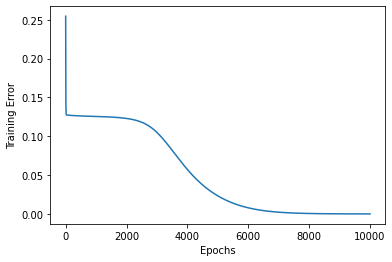

In [16]:
n_epochs = 10000
learning_rate = 0.12
training_errors = []

input_size = 2
hidden_size = 3
output_size = 1

# re-initialize the weights to be sure we start fresh
w1, w2 = initialize_weights(input_size, hidden_size, output_size)

for epoch in range(n_epochs):
 
    # Step 1: forward pass
    act_hidden, y_hat = forward_pass(X, w1, w2)
    
    # Step 2: backward pass
    dw2, dw1, error = backward_pass(X, y_hat, y, w1, w2, act_hidden)
    
    # Step 3: apply gradients scaled by learning rate
    w2 = w2 - learning_rate * dw2
    w1 = w1 - learning_rate * dw1
    
    # Step 4: some book-keeping and print-out
    if epoch % 200 == 0:
        print('Epoch %d> Training error: %f' % (epoch, error))
    training_errors.append([epoch, error])

# Plot training error progression over time
training_errors = np.asarray(training_errors)
plt.plot(training_errors[:, 0], training_errors[:, 1]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

If everything is correct the error should be going down.


## Predictions and Visualization

Now that we have a trained neural network let's try and see if it can actually correctly solve the XOR problem. Does the following look like what you would expect to see?

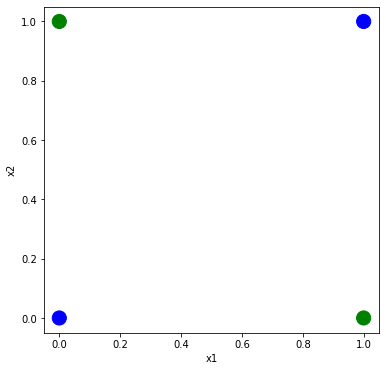

In [18]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y_hat = [np.round(forward_pass(x, w1, w2)[1]) for x in X]

# Colors corresponding to class predictions y_hat.
colors = ['green' if y_ == 1 else 'blue' for y_ in y_hat] 

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.scatter(X[:,0],X[:,1],s=200,c=colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In the beginning we said that a linear model will not be able to solve the XOR problem. Hence, the decision boundary of our neural network must be non-linear. But how exactly does it look? Where does the network switch from labeling a point als "blue" to labeling it "green"? To visualize this we can sub-sample the space $[0, 1]^2$, get the predictions from the model for all these points and visualize them.

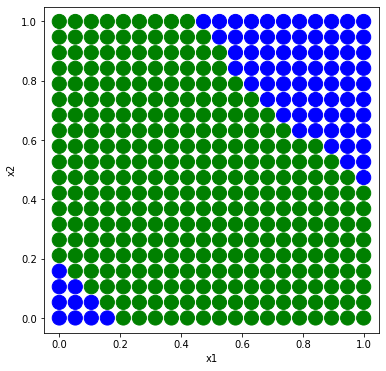

In [19]:
resolution = 20
min_x, min_y = 0.0, 0.0
max_x, max_y = 1.0, 1.0
xv, yv = np.meshgrid(np.linspace(min_x, max_x, resolution), np.linspace(min_y, max_y, resolution))
X_extended = np.concatenate([xv[..., np.newaxis], yv[..., np.newaxis]], axis=-1)
X_extended = np.reshape(X_extended, [-1, 2])
y_hat = [np.round(forward_pass(x, w1, w2)[1]) for x in X_extended]

# Colors corresponding to class predictions y_hat.
colors = ['green' if y_ == 1 else 'blue' for y_ in y_hat] 

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.scatter(X_extended[:,0],X_extended[:,1],s=200,c=colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()